**Applied Machine Learning - Homework 3 (Question 1)**

**Group Members:**

1. Yash Takte
2. Sejal Nimkar
3. Niranjan Tapasvi
4. Neha Kothavade

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.model_selection import train_test_split
from scipy.spatial import procrustes
from scipy.stats import mode, pearsonr
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Define the image folder path
image_folder = "D:\\MS\\Indiana University Bloomington\\Classes\\Applied Machine Learning (Zoran Tiganj - CSCI-P 556)\\Homework\\Homework 3 Q1\\360 Rocks"

# Initialize lists to store images and labels
images = []
labels = []

# Load images and labels
for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img = Image.open(os.path.join(image_folder, filename)).convert('L')  # Convert to grayscale
        img = img.resize((64, 64))  # Resize to 64x64 pixels
        images.append(np.array(img).flatten()) 
        labels.append(filename[0])  # First letter indicates category

# Convert images list to a data matrix
data_matrix = np.array(images)

In [4]:
# Standardize the data matrix
scaler = StandardScaler()
data_matrix_scaled = scaler.fit_transform(data_matrix)

# **Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 90% of the variance?**

**Question 1 ->**

Number of components to preserve 90% variance: 96


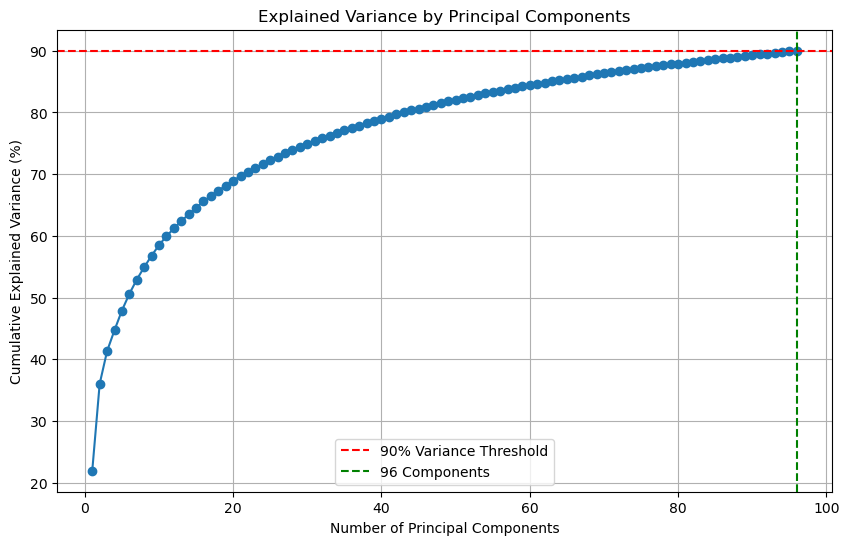

In [7]:
# Perform PCA for 90% explained variance
pca = PCA(0.90)
pca.fit(data_matrix_scaled)
n_components_90_variance = pca.n_components_
print(f"Number of components to preserve 90% variance: {n_components_90_variance}")

# Transform data to reduced dimension
data_matrix_reduced = pca.transform(data_matrix_scaled)

# Plot cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=90, color='r', linestyle='--', label="90% Variance Threshold")
plt.axvline(x=n_components_90_variance, color='g', linestyle='--', label=f"{n_components_90_variance} Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.grid(True)
plt.show()

# **Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA.**

**Question 2 ->**

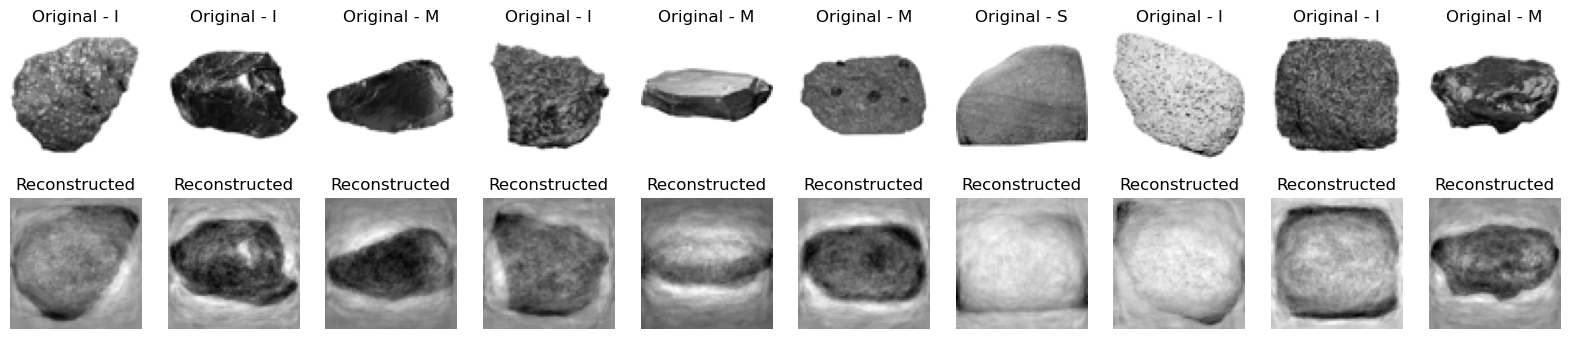

In [10]:
# Reconstruct images with PCA preserving 90% variance
data_matrix_reconstructed = pca.inverse_transform(data_matrix_reduced)

# Select random images to plot
num_images = 10
indices = np.random.choice(len(data_matrix), num_images, replace=False)
selected_images_original = data_matrix[indices]
selected_images_reconstructed = data_matrix_reconstructed[indices]

# Plot original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(num_images):
    # Original
    plt.subplot(2, num_images, i + 1)
    plt.imshow(selected_images_original[i].reshape(64, 64), cmap="gray")
    plt.axis("off")
    plt.title(f"Original - {labels[indices[i]]}")

    # Reconstructed
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(selected_images_reconstructed[i].reshape(64, 64), cmap="gray")
    plt.axis("off")
    plt.title("Reconstructed")
plt.show()

# **Each of the images belongs to one of three rock categories. The category is indicated by the first letter in the filename (I, M and S). We will now try to see if the visualization can help us identify different clusters.**

**A. Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?**

**B. Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data (your visualization should look similar to the one after line 71 in this file https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynb to an external site. but with images of rocks instead of MNIST digits). Repeat the process and create the same type of plots for t-SNE, LLE and MDS.**

**C. Discuss your observations.**

**Question 3 A ->**

Variance explained by the first two components: 36.01%


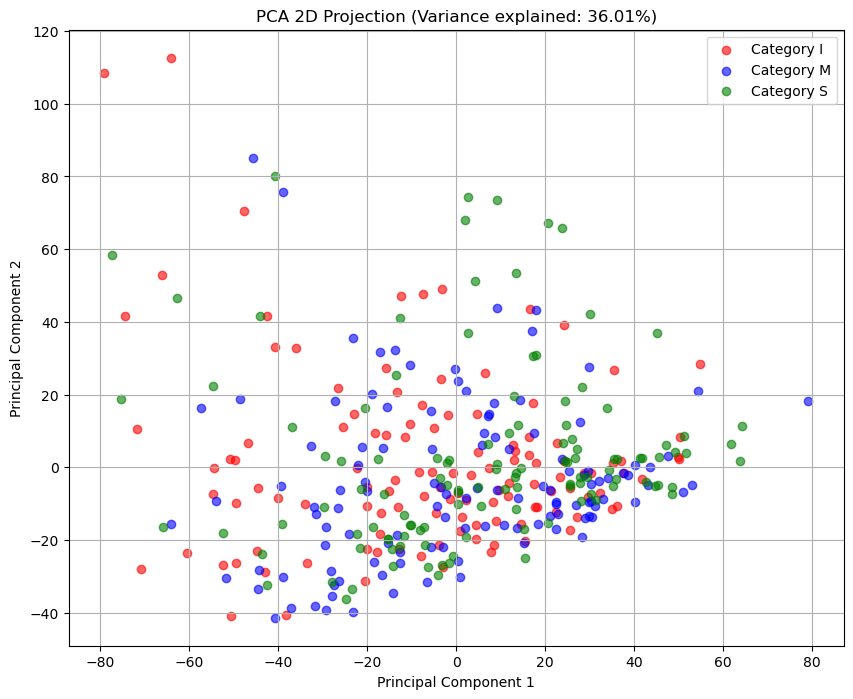

In [13]:
# PCA with 2 components
pca_2d = PCA(n_components=2)
data_matrix_2D_pca = pca_2d.fit_transform(data_matrix_scaled)
explained_variance_2d = np.sum(pca_2d.explained_variance_ratio_) * 100
print(f"Variance explained by the first two components: {explained_variance_2d:.2f}%")

# Scatter plot of the 2D PCA results
categories = ['I', 'M', 'S']
colors = {'I': 'red', 'M': 'blue', 'S': 'green'}
plt.figure(figsize=(10, 8))
for category in categories:
    indices = [i for i, label in enumerate(labels) if label == category]
    plt.scatter(data_matrix_2D_pca[indices, 0], data_matrix_2D_pca[indices, 1], 
                label=f"Category {category}", color=colors[category], alpha=0.6)

plt.title(f"PCA 2D Projection (Variance explained: {explained_variance_2d:.2f}%)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Helper function to plot with image overlays
def plot_with_images(X_2D, labels, images, title, min_distance=0.1, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X_2D)
    label_color_map = {'I': 'red', 'M': 'blue', 'S': 'green'}
    colors = [label_color_map[label] for label in labels]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=colors, alpha=0.5, edgecolor='k')

    # Limit number of image overlays
    max_images = 40  # Limit the number of images
    indices = np.random.choice(len(X_normalized), size=min(max_images, len(X_normalized)), replace=False)

    for index in indices:
        img = images[index].reshape(64, 64)
        imagebox = AnnotationBbox(OffsetImage(img, cmap="gray", zoom=0.5), X_normalized[index], frameon=False)
        ax.add_artist(imagebox)

    plt.title(title)
    plt.axis("off")
    plt.show()

**Question 3 B ->**

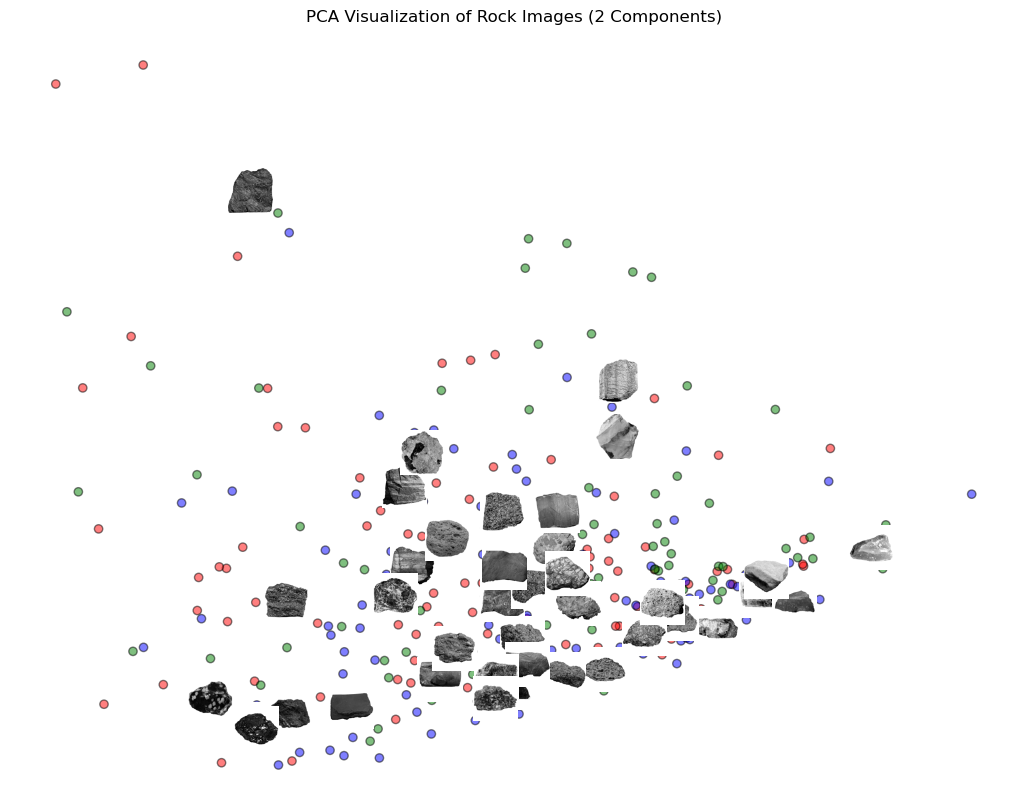

In [16]:
# PCA 2D scatter with image overlays
plot_with_images(data_matrix_2D_pca, labels, data_matrix, "PCA Visualization of Rock Images (2 Components)")

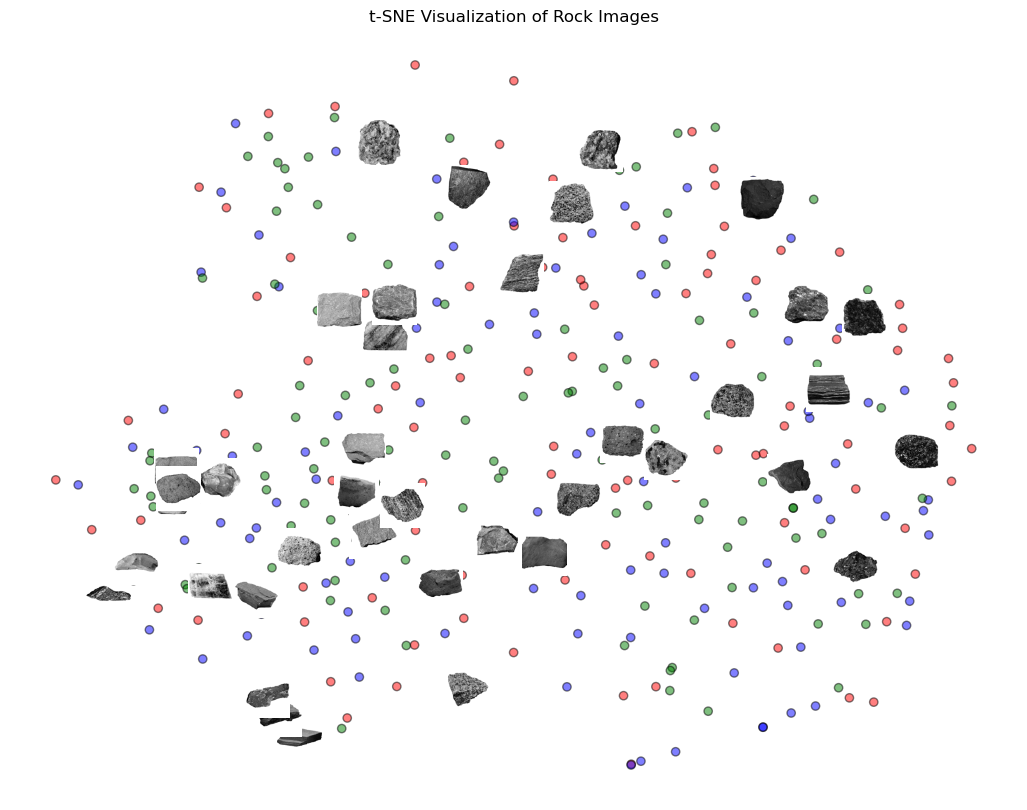

In [17]:
# t-SNE 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_matrix_2D_tsne = tsne.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_tsne, labels, data_matrix, "t-SNE Visualization of Rock Images")

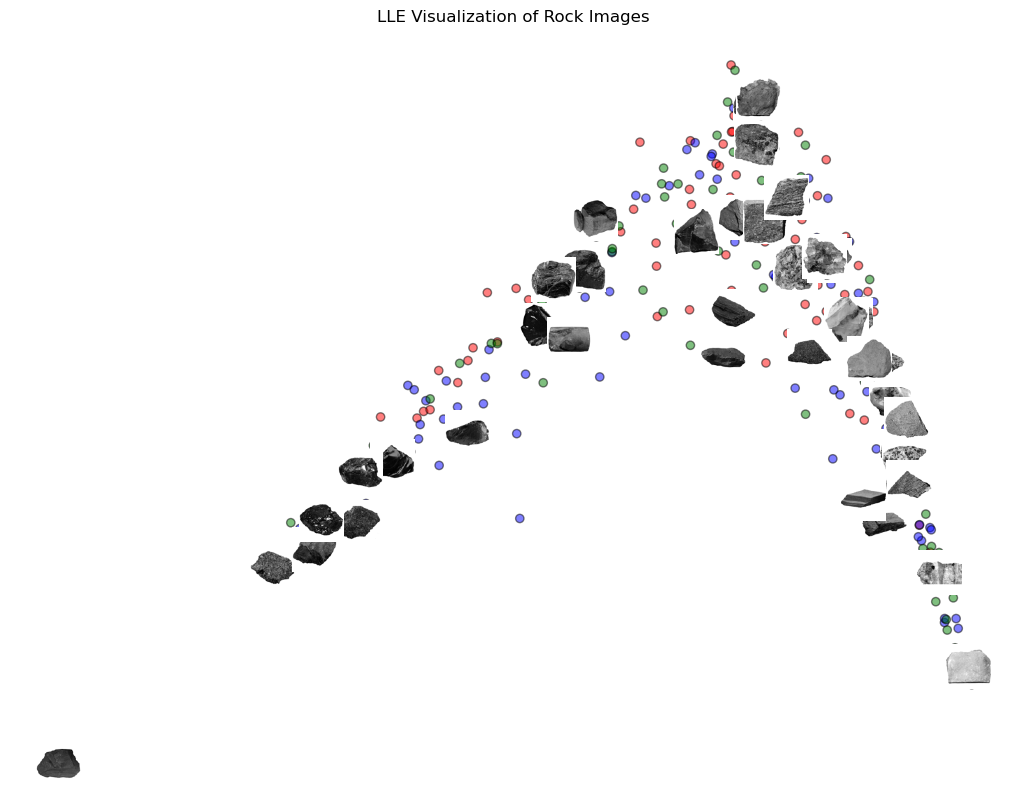

In [18]:
# LLE 2D
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
data_matrix_2D_lle = lle.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_lle, labels, data_matrix, "LLE Visualization of Rock Images")

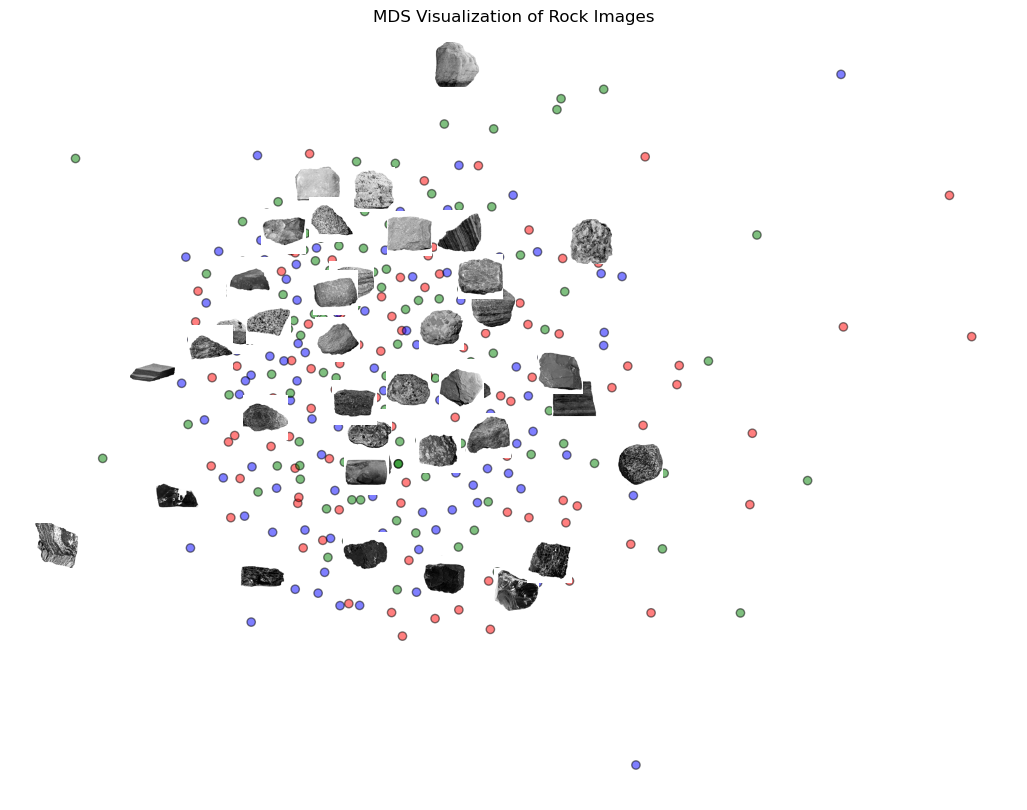

In [19]:
# MDS 2D
mds = MDS(n_components=2, random_state=42)
data_matrix_2D_mds = mds.fit_transform(data_matrix_scaled)
plot_with_images(data_matrix_2D_mds, labels, data_matrix, "MDS Visualization of Rock Images")

**Question 3 C ->**

**Discussion on the visualizations.**

**1. PCA Visualization**

In the PCA visualization, the rocks are spread out across the plot without forming clear clusters. PCA is a method that shows the main patterns in the data using a straightforward, linear approach. This spread means that PCA captures the overall variation in the data but doesn’t highlight strong groupings among the rocks. The scattered arrangement suggests that PCA might not be the best method for finding clusters of similar rocks.

**2. t-SNE Visualization**

The t-SNE visualization shows rocks grouped into tighter clusters. This method is good at capturing complex relationships, so rocks that look similar are placed close together. Compared to PCA, the t-SNE layout has more defined clusters, making it easier to see differences between groups of rocks. However, t-SNE sometimes creates clusters that may not be accurate for larger datasets, as it focuses more on local patterns rather than the global structure.

**3. LLE (Locally Linear Embedding) Visualization**

The LLE visualization arranges the rocks in an elongated, curved shape, showing a possible continuous pattern in the dataset. This arrangement suggests that LLE found a hidden structure within the rock images. Rocks with similar textures or features are placed close to each other along the curve. LLE works well for datasets that follow gradual changes, so the shape may reflect a progression in features like texture, size, or shape.

**4. MDS (Multi-Dimensional Scaling) Visualization**

In the MDS visualization, most of the rocks are clustered in a circular shape, with some scattered along the edges. MDS focuses on preserving the distances between data points, showing how similar or different the rocks are. The central cluster suggests that many rocks share common features, while the scattered points on the edges represent rocks that are different. While MDS gives a good overall view, it may not reveal small, detailed patterns as well as t-SNE or LLE.

# **Now let's see if these dimensionality reduction techniques can give us similar features to those that humans use to judge the images. File mds_360.txt contains 8 features for each of the images (rankings are in the same order as the images in  '360 Rocks' folder. Run PCA, LLE and MDS to reduce the dimensionality of the images to 8. Then, compare those image embeddings with the ones from humans that are in the mds_360.txt file. Use Procrustes analysis to do the comparison (here is one example of how to do that mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data). Here matrix_with_human_data and matrix_with_pca_embeddings_data should be 360 by 8. disparity will tell you the difference in the data. Report disparity for each of the three dimensionality reduction methods. Compute the correlation coefficient between each dimension of mtx1 and mtx2 for each of the three methods - display results in a table.**

**Question 4 ->**

In [23]:
# Load human rankings from mds_360.txt
human_data = np.loadtxt("D:\\MS\\Indiana University Bloomington\\Classes\\Applied Machine Learning (Zoran Tiganj - CSCI-P 556)\\Homework\\Homework 3 Q1\\mds_360.txt")
print("Shape of human data:", human_data.shape)

Shape of human data: (360, 8)


In [24]:
# Dimensionality Reduction to 8 Dimensions on Image Data
embeddings = {
    'PCA': PCA(n_components=8).fit_transform(data_matrix_scaled),
    't-SNE': TSNE(n_components=8, random_state=42, method="exact").fit_transform(data_matrix_scaled),
    'LLE': LocallyLinearEmbedding(n_components=8, random_state=42).fit_transform(data_matrix_scaled),
    'MDS': MDS(n_components=8, random_state=42).fit_transform(data_matrix_scaled)
}

# Procrustes Analysis
disparities = {}
aligned_matrices = {}
for method, embed in embeddings.items():
    mtx1, mtx2, disparity = procrustes(human_data, embed)
    disparities[method] = disparity
    aligned_matrices[method] = (mtx1, mtx2)
    print(f"{method} embedding shape:", embed.shape)
    print(f"{method} disparity with human data: {disparity:.4f}")

PCA embedding shape: (360, 8)
PCA disparity with human data: 0.8674
t-SNE embedding shape: (360, 8)
t-SNE disparity with human data: 0.9296
LLE embedding shape: (360, 8)
LLE disparity with human data: 0.9078
MDS embedding shape: (360, 8)
MDS disparity with human data: 0.8814


Correlation coefficients between each dimension of mtx1 and mtx2:
                  PCA     t-SNE       LLE       MDS
Dimension 1  0.857580  0.712250  0.793314  0.854693
Dimension 2  0.144730  0.190087  0.281389  0.225030
Dimension 3  0.244418  0.165790  0.237586  0.264437
Dimension 4  0.304410  0.209424  0.232424  0.319460
Dimension 5  0.169693  0.135868  0.112935  0.161852
Dimension 6  0.270861  0.206371  0.223721  0.241874
Dimension 7  0.198097  0.200900  0.290112  0.202135
Dimension 8  0.047837  0.037266  0.077815  0.020447


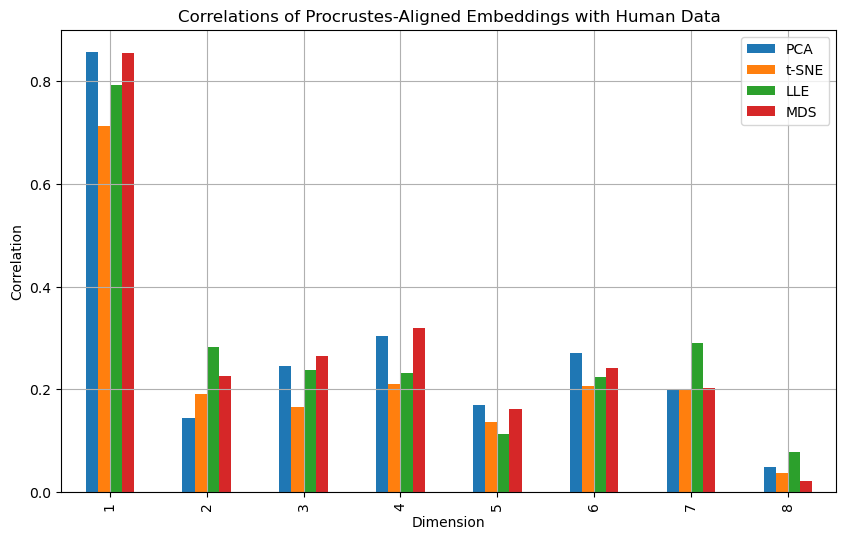

In [25]:
# Correlation between mtx1 and mtx2 for each method
correlation_results = {}
for method, (mtx1, mtx2) in aligned_matrices.items():
    correlations = [np.corrcoef(mtx1[:, i], mtx2[:, i])[0, 1] for i in range(8)]
    correlation_results[method] = correlations

# Convert results to DataFrame for better readability
correlation_df = pd.DataFrame(correlation_results, index=[f"Dimension {i+1}" for i in range(8)])
print("Correlation coefficients between each dimension of mtx1 and mtx2:")
print(correlation_df)

# Display correlation results
correlation_df = pd.DataFrame(correlation_results)
correlation_df.index = correlation_df.index + 1 
correlation_df.plot(kind="bar", figsize=(10, 6))
plt.title("Correlations of Procrustes-Aligned Embeddings with Human Data")
plt.xlabel("Dimension")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()

# **Cluster the 360 images using K-Means.**

**A. You can reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.**

**B. Set the number of clusters to 3 and report clustering accuracy.**

**Question 5 A ->**

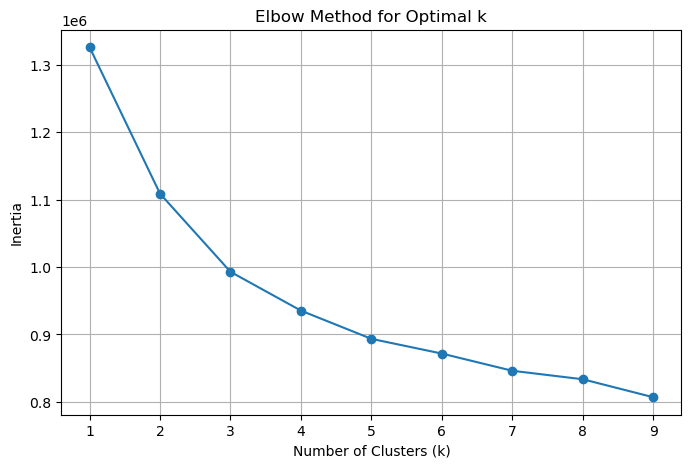

In [28]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_matrix_reduced)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

**Based on the Elbow Method plot, the optimal number of clusters for this dataset appears to be k = 3.**

**Question 5 B ->**

In [30]:
# Apply K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(data_matrix_reduced)

# Convert true labels to numerical format
label_mapping = {'I': 0, 'M': 1, 'S': 2}
true_labels = np.array([label_mapping[label] for label in labels])

# Map each cluster label to true label using majority voting
mapped_labels_kmeans = np.zeros_like(cluster_labels_kmeans)
for i in range(3):
    mask = (cluster_labels_kmeans == i)
    mapped_labels_kmeans[mask] = mode(true_labels[mask])[0]

# Calculate accuracy
accuracy_kmeans = accuracy_score(true_labels, mapped_labels_kmeans)
print(f"K-Means Clustering Accuracy with k=3: {accuracy_kmeans * 100:.2f}%")

K-Means Clustering Accuracy with k=3: 36.11%


# **Cluster the 360 images using EM.**

**A. You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.** 

**B. Set the number of clusters to 3 and report clustering accuracy.** 

**C. Use the model to generate 20 new rocks (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).**

**Question 6 A ->**

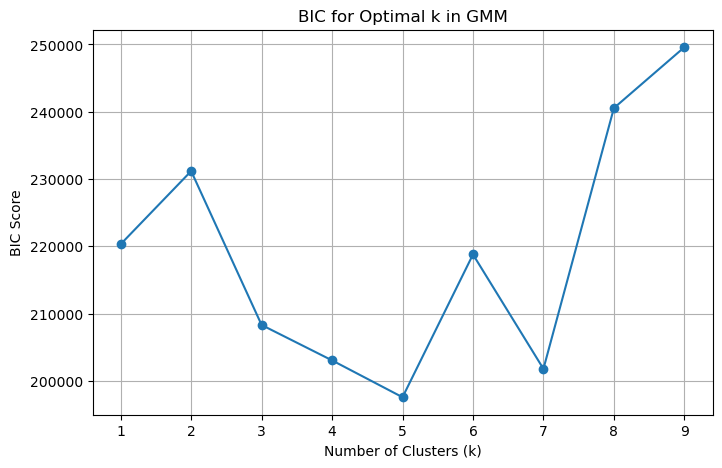

In [33]:
bic_scores = []
K_range = range(1, 10)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(data_matrix_reduced)
    bic_scores.append(gmm.bic(data_matrix_reduced))

# Plot BIC scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, bic_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC Score")
plt.title("BIC for Optimal k in GMM")
plt.grid(True)
plt.show()

**Based on the BIC plot, k=5 appears to be the optimal number of clusters.**

**Question 6 B ->**

In [35]:
# Fit GMM with k=3
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(data_matrix_reduced)

# Map GMM cluster labels to true labels using majority voting
mapped_labels_gmm = np.zeros_like(gmm_labels)
for i in range(3):
    mask = (gmm_labels == i)
    mapped_labels_gmm[mask] = mode(true_labels[mask])[0]

# Calculate accuracy
accuracy_gmm = accuracy_score(true_labels, mapped_labels_gmm)
print(f"GMM Clustering Accuracy with k=3: {accuracy_gmm * 100:.2f}%")

GMM Clustering Accuracy with k=3: 35.56%


**Question 6 C ->**

Shape of new_samples_original: (20, 4096)


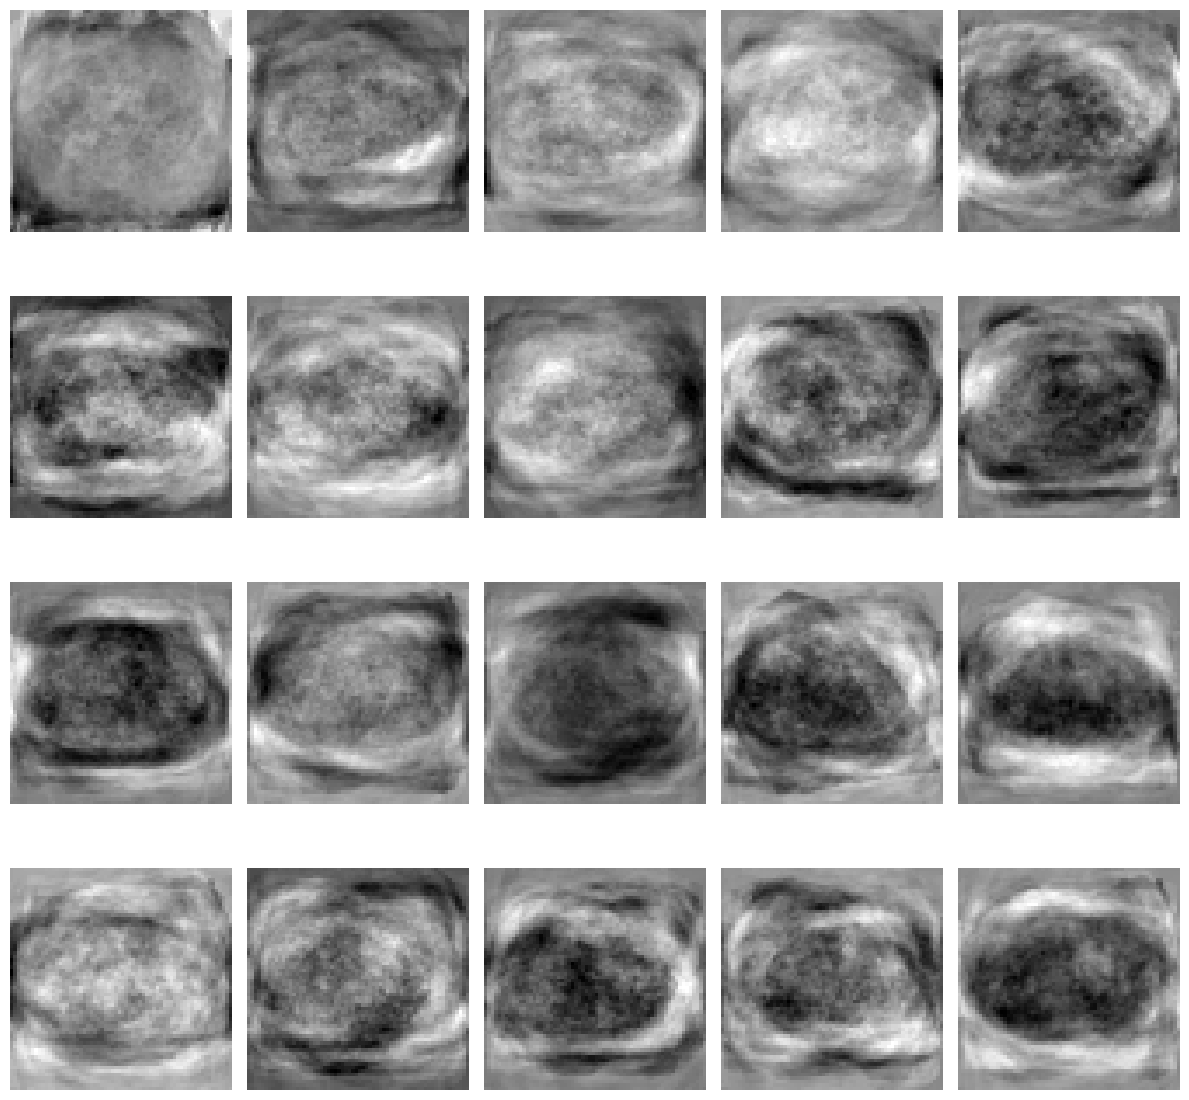

In [37]:
# Generate 20 new samples using the GMM model
num_samples = 20
new_samples_reduced, _ = gmm.sample(num_samples) 

# Inverse transform the reduced samples back to the original image space
new_samples_original = pca.inverse_transform(new_samples_reduced)

# Check the shape of new_samples_original
print(f"Shape of new_samples_original: {new_samples_original.shape}")

# Visualize the 20 new "rocks"
fig, axes = plt.subplots(4, 5, figsize=(12, 12))  # 4 rows, 5 columns for 20 images
axes = axes.flatten()

# Loop through and visualize the new samples
for i in range(num_samples):
    axes[i].imshow(new_samples_original[i].reshape(64, 64), cmap='gray')  
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

# **Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on 360 rock images using rock name as the label - the category is indicated by the first letter in the filename (I, M and S). Use images from '120 Rocks' folder as your validation data. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training. We recommend using Colab (the free version should be totally fine), but make sure to run it with a GPU to speed up the training - to add a GPU on Colab go to Edit->Notebook settings).**

**A. Report the training time (use code to do this).**

**B. Plot training and validation loss and accuracy as a function of training epochs.** 

**C. How many parameters does the network have? How many of those parameters are bias parameters?** 

**D. Compare the activity of neurons in the next to the last layer (the one with 8 neurons) with the human data. (to get human data use mds_360.txt and mds_120.txt files). Similar to before, use Procrustes analysis to do the comparison.  For training and validation data (separately), report disparity and compute the correlation coefficient between each dimension of mtx1 and mtx2. Display results in a table.** 

In [39]:
# Paths for training and validation datasets
train_folder = "D:\\MS\\Indiana University Bloomington\\Classes\\Applied Machine Learning (Zoran Tiganj - CSCI-P 556)\\Homework\\Homework 3 Q1\\360 Rocks"
val_folder = "D:\\MS\\Indiana University Bloomington\\Classes\\Applied Machine Learning (Zoran Tiganj - CSCI-P 556)\\Homework\\Homework 3 Q1\\120 Rocks"

# Function to load and preprocess images
def load_images(image_folder, image_size=(64, 64)):
    images = []
    labels = []
    
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = load_img(os.path.join(image_folder, filename), target_size=image_size, color_mode='grayscale')
            img_array = img_to_array(img)
            images.append(img_array)
            
            label = filename[0].upper()  # Use the first character as label
            labels.append(label)
    
    images = np.array(images).astype('float32') / 255.0  # Normalize images
    labels = np.array(labels)
    
    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)  # One-hot encoding for categorical labels
    
    return images, labels

# Load the data
train_images, train_labels = load_images(train_folder)
val_images, val_labels = load_images(val_folder)

**Question 7 A & 7 B ->**

In [41]:
# Build the feedforward neural network using Functional API
input_shape = (64, 64, 1)
num_classes = 3

inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(8, activation='relu')(x)  # Next-to-last layer with 8 neurons
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Early stopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
start_time = time.time()
history = model.fit(
    train_images, 
    train_labels, 
    epochs=30, 
    batch_size=32, 
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping]  # Add early stopping here
)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time with Early Stopping: {training_time:.2f} seconds")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 691,427 (2.64 MB)

 Trainable params: 691,427 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.3141 - loss: 1.1139 - val_accuracy: 0.3667 - val_loss: 1.0979
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3349 - loss: 1.0986 - val_accuracy: 0.3417 - val_loss: 1.0987
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3469 - loss: 1.0971 - val_accuracy: 0.3333 - val_loss: 1.0827
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3324 - loss: 1.1052 - val_accuracy: 0.4167 - val_loss: 1.0712
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4078 - loss: 1.0725 - val_accuracy: 0.3917 - val_loss: 1.0886
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3201 - loss: 1.0968 - val_accuracy: 0.4167 - val_loss: 1.0641
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4181 - loss: 1.0682 - val_accuracy: 0.4250 - val_loss: 1.0314
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.4333 - loss: 1.0433 - val_accuracy: 0.5000 - v

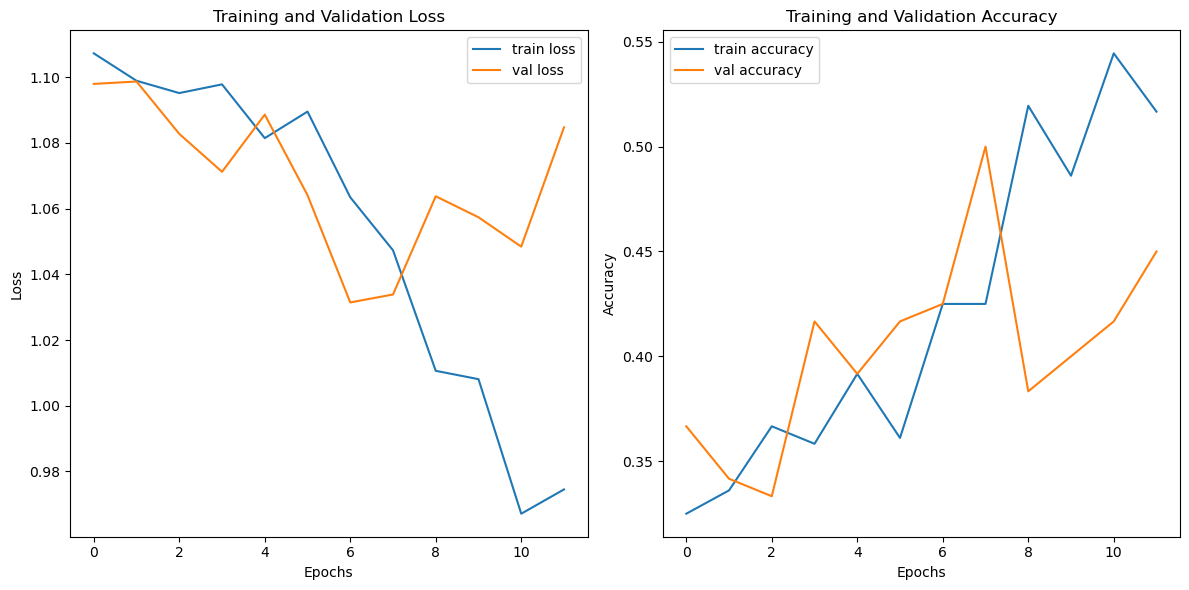

In [42]:
# Plot training and validation loss and accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

**Question 7 C ->**

In [44]:
# Calculate the total number of parameters
total_params = model.count_params()

# Calculate the number of bias parameters
bias_params = sum(np.prod(p.shape) for p in model.trainable_weights if 'bias' in p.name)

print(f"Total parameters: {total_params}")
print(f"Bias parameters: {bias_params}")

Total parameters: 691427
Bias parameters: 427


**Question 7 D ->**

In [46]:
# Procrustes Analysis on Next-to-Last Layer
human_train_data = np.loadtxt("D:\\MS\\Indiana University Bloomington\\Classes\\Applied Machine Learning (Zoran Tiganj - CSCI-P 556)\\Homework\\Homework 3 Q1\\mds_360.txt")
human_val_data = np.loadtxt("D:\\MS\\Indiana University Bloomington\\Classes\\Applied Machine Learning (Zoran Tiganj - CSCI-P 556)\\Homework\\Homework 3 Q1\\mds_120.txt")

def get_activations(model, data):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    return intermediate_layer_model.predict(data)

# Get activations for training and validation
train_activations = get_activations(model, train_images)
val_activations = get_activations(model, val_images)

def procrustes_analysis_and_correlation(human_data, activations):
    min_dim = min(human_data.shape[0], activations.shape[0])
    mtx1, mtx2, disparity = procrustes(human_data[:min_dim], activations[:min_dim])

    correlations = [pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])]
    return disparity, correlations

train_disparity, train_correlations = procrustes_analysis_and_correlation(human_train_data, train_activations)
val_disparity, val_correlations = procrustes_analysis_and_correlation(human_val_data, val_activations)

# Create a DataFrame for disparity
disparity_df = pd.DataFrame({
    'Metric': ['Disparity'],
    'Training': [train_disparity],
    'Validation': [val_disparity]
})

# Create a DataFrame for correlation dimensions
correlation_df = pd.DataFrame({
    'Metric': [f'Correlation Dim {i+1}' for i in range(8)],
    'Training': train_correlations,
    'Validation': val_correlations
})

# Combine the disparity and correlation DataFrames
results = pd.concat([disparity_df, correlation_df], ignore_index=True)

# Display the table
print(results)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
              Metric  Training  Validation
0          Disparity  0.833837    0.864805
1  Correlation Dim 1  0.676757    0.678401
2  Correlation Dim 2  0.424282    0.346546
3  Correlation Dim 3  0.309967    0.381740
4  Correlation Dim 4  0.448410    0.290289
5  Correlation Dim 5  0.149592    0.134752
6  Correlation Dim 6  0.237217    0.124047
7  Correlation Dim 7  0.272559    0.063004
8  Correlation Dim 8  0.265294    0.468478


**The model aligns well with human data in Dimension 1 but performs poorly in other dimensions. Overall, the disparity values show a significant gap between the model and human data.**